## Why are the most painted pixels the most painted?

In [39]:
parquet_file = "rPlace.parquet"

In [5]:
import duckdb
con = duckdb.connect()
    
# Ranking of Colors by Distinct Users
top_pixels = con.execute(f"""
                        SELECT x, y, COUNT(*) AS paint_count
                        FROM {parquet_file}
                        GROUP BY x, y
                        ORDER BY paint_count DESC
                        LIMIT 3;
                        """).fetchall()
print("**Top Ranking of Pixel Locations**")
for i, res in enumerate(top_pixels):
    print(f"{i + 1}. ({res[0]},{res[1]}) , freq: {res[2]}")

**Top Ranking of Pixel Locations**
1. (0,0) , freq: 98807
2. (359,564) , freq: 69198
3. (349,564) , freq: 55230


### These pixels are most painted because users repeatedly placed pixels in those locations.

## Why did users repeatedly place pixels in those locations?

In [28]:
radius = 10
location_paint_frequencies = []
print("**Paint Count Around Top Pixel Locations**")
for i, res in enumerate(top_pixels):
    activity = con.execute(f"""
                            SELECT SUM(1) AS paint_activity
                            FROM {parquet_file}
                            WHERE ABS(x - {res[0]}) <= {radius} AND ABS(y - {res[1]} - 0) <= {radius}
                            """).fetchall()
    location_paint_frequencies.append(activity[0][0])
    print(f"{i + 1}. ({res[0]},{res[1]}) , Paint Count: {activity[0][0]}") 

    
num_samples = 500 
random_sample_avg = duckdb.execute(f"""
                                    WITH random_samples AS (
                                        SELECT DISTINCT x, y
                                        FROM {parquet_file}
                                        ORDER BY RANDOM()
                                        LIMIT {num_samples}
                                    )
                                    SELECT SUM(1) / {num_samples} AS avg_paint_activity_per_region
                                    FROM {parquet_file} AS p
                                    JOIN random_samples AS rs
                                    ON ABS(p.x - rs.x) <= {radius} AND ABS(p.y - rs.y) <= {radius};
                                """).fetchone()[0]

location_paint_frequencies.append(random_sample_avg)
print(f"Average Paint Count for Randomly Sampled Areas: {random_sample_avg}")


**Paint Count Around Top Pixel Locations**
1. (0,0) , Paint Count: 197544
2. (359,564) , Paint Count: 275450
3. (349,564) , Paint Count: 256406
Average Paint Count for Randomly Sampled Areas: 15587.71


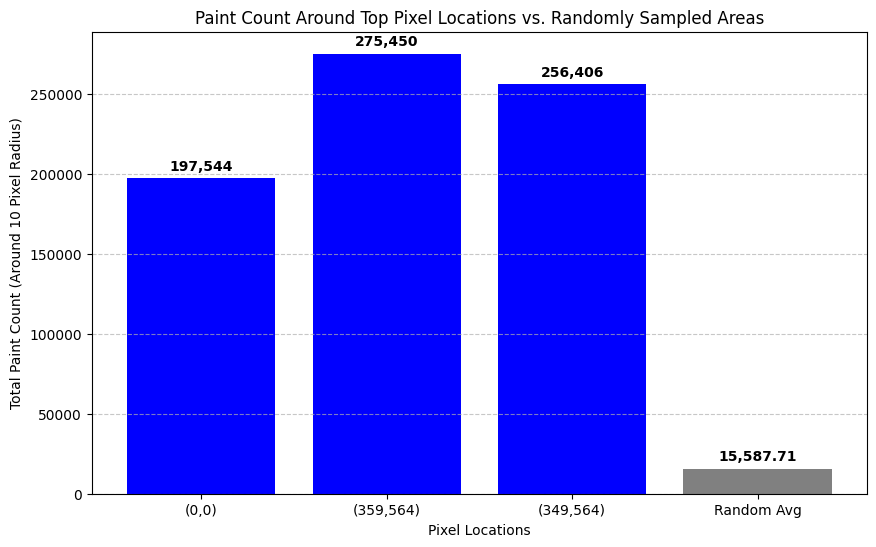

In [35]:
top_pixel_labels = ["(0,0)", "(359,564)", "(349,564)", "Random Avg"]

# Create figure and bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_pixel_labels, location_paint_frequencies, color=["blue", "blue", "blue", "gray"])

# Labels and title
ax.set_xlabel("Pixel Locations")
ax.set_ylabel("Total Paint Count (Around 10 Pixel Radius)")
ax.set_title("Paint Count Around Top Pixel Locations vs. Randomly Sampled Areas")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show values on bars
for i, v in enumerate(location_paint_frequencies):
    ax.text(i, v + 5000, f"{v:,}", ha="center", fontsize=10, fontweight="bold")

# Show plot
plt.show()


### Top pixel locations were in areas that had significantly higher activity than the average randomly sampled areas. This suggests that users were focused on these locations and not just the individual pixels themselves.

## Why were users focused on these locations?

In [30]:
pixel_color_changes = []

print("**Paint Color Changes at Top Pixel Locations**")
for i, res in enumerate(top_pixels):
    changes = con.execute(f"""
                            WITH color_changes AS (
                                SELECT
                                    pixel_color, 
                                    timestamp,
                                    LAG(pixel_color) OVER (PARTITION BY x, y ORDER BY timestamp) AS prev_color
                                FROM {parquet_file}
                                WHERE x == {res[0]} AND y == {res[1]}
                            )
                            SELECT 
                                COUNT(*) AS total_color_changes
                            FROM color_changes
                            WHERE pixel_color != prev_color
                            """).fetchall()
    pixel_color_changes.append(changes[0][0])
    print(f"{i + 1}. ({res[0]},{res[1]}) , Paint Count: {changes[0][0]}") 

    
num_samples = 500 
random_sample_avg = duckdb.execute(f"""
                            WITH random_samples AS (
                                SELECT DISTINCT x, y
                                FROM {parquet_file}
                                ORDER BY RANDOM()
                                LIMIT {num_samples}
                            ),
                            color_changes AS (
                                SELECT 
                                    p.x,
                                    p.y,
                                    p.pixel_color, 
                                    p.timestamp,
                                    LAG(p.pixel_color) OVER (PARTITION BY p.x, p.y ORDER BY p.timestamp) AS prev_color
                                FROM {parquet_file} AS p
                                JOIN random_samples AS rs 
                                ON p.x = rs.x AND p.y = rs.y
                            )
                            SELECT 
                                COUNT(*) / {num_samples} AS avg_color_changes
                            FROM color_changes
                            WHERE pixel_color != prev_color;""").fetchone()[0]
pixel_color_changes.append(random_sample_avg)
print(f"Color Changes for Randomly Sampled Areas: {random_sample_avg}")

**Paint Color Changes at Top Pixel Locations**
1. (0,0) , Paint Count: 57650
2. (359,564) , Paint Count: 48668
3. (349,564) , Paint Count: 40429
Color Changes for Randomly Sampled Areas: 28.032


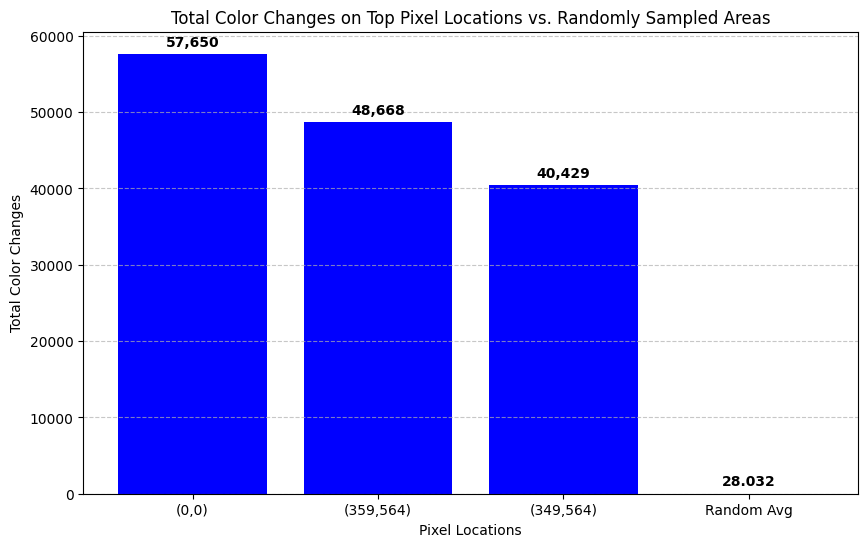

In [37]:
top_pixel_labels = ["(0,0)", "(359,564)", "(349,564)", "Random Avg"]

# Create figure and bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_pixel_labels, pixel_color_changes, color=["blue", "blue", "blue", "gray"])

# Labels and title
ax.set_xlabel("Pixel Locations")
ax.set_ylabel("Total Color Changes")
ax.set_title("Total Color Changes on Top Pixel Locations vs. Randomly Sampled Areas")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show values on bars
for i, v in enumerate(pixel_color_changes):
    ax.text(i, v + 1000, f"{v:,}", ha="center", fontsize=10, fontweight="bold")

# Show plot
plt.show()

1. (0,0) , Top 5 Colors: [('#FFFFFF', 59282), ('#000000', 8715), ('#FF4500', 4209), ('#811E9F', 2200), ('#BE0039', 2189)]
2. (359,564) , Top 5 Colors: [('#000000', 34726), ('#51E9F4', 26940), ('#FF4500', 1656), ('#FFFFFF', 1391), ('#3690EA', 860)]
3. (349,564) , Top 5 Colors: [('#000000', 27804), ('#51E9F4', 19404), ('#FF4500', 2120), ('#FFFFFF', 1512), ('#BE0039', 846)]
[['#FFFFFF', '#000000', '#FF4500', '#811E9F', '#BE0039'], ['#000000', '#51E9F4', '#FF4500', '#FFFFFF', '#3690EA'], ['#000000', '#51E9F4', '#FF4500', '#FFFFFF', '#BE0039']]
[[59282, 8715, 4209, 2200, 2189], [34726, 26940, 1656, 1391, 860], [27804, 19404, 2120, 1512, 846]]


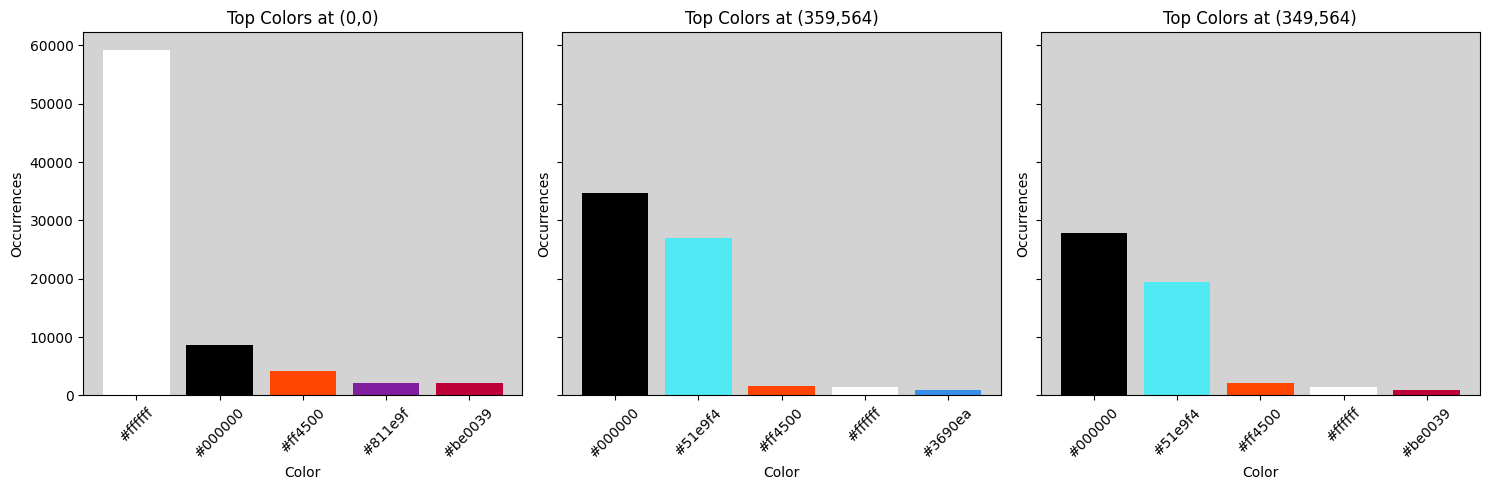

In [27]:
import matplotlib.pyplot as plt

pixel_color_counts = []
pixel_colors = []

for i, res in enumerate(top_pixels):
    color_counts = con.execute(f"""
        SELECT pixel_color, COUNT(*) AS occurrences
        FROM {parquet_file}
        WHERE x = {res[0]} AND y = {res[1]}
        GROUP BY pixel_color
        ORDER BY occurrences DESC
        LIMIT 5;
    """).fetchall()

    c = []
    f = []
    for pair in color_counts:
        c.append(pair[0])
        f.append(pair[1])
    pixel_colors.append(c)
    pixel_color_counts.append(f)
    print(f"{i + 1}. ({res[0]},{res[1]}) , Top 5 Colors: {color_counts}")

locations = ["(0,0)", "(359,564)", "(349,564)"]

print(pixel_colors)
print(pixel_color_counts)
# Convert colors to lowercase and ensure they are strings
for i in range(len(pixel_colors)):
    pixel_colors[i] = [str(c).lower().strip() for c in pixel_colors[i]]

# Create subplots for each pixel location
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Generate bar charts for each pixel location
for i, ax in enumerate(axes):
    ax.bar(range(len(pixel_colors[i])), pixel_color_counts[i], color=pixel_colors[i], tick_label=pixel_colors[i])  # Use corrected colors
    ax.set_title(f"Top Colors at {locations[i]}")
    ax.set_xlabel("Color")
    ax.set_ylabel("Occurrences")
    ax.tick_params(axis='x', rotation=45)
    ax.set_facecolor("lightgrey")  # Set subplot background to grey

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### The high color change frequency combined with the fact that these pixels were consistently one or two colors supports the idea that these pixels were controlled by large communities that worked hard to defend them.

## Why did large communities attempt to defend these pixel locations?

### Large communities defended certain pixels because they were part of larger symbolic artworks. Defending these pixels and the area around them allowed communities to keep their artwork visible in rPlace.